In [ ]:
#importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
#load dataset
df = pd.read_csv('bank_transactions_data_2.csv')

In [ ]:
#CLEANING

display(df.head())
target='TransactionAmount'
num_feat=['CustomerAge','TransactionDuration','LoginAttempts','AccountBalance']
cat_feat=['TransactionID','AccountID','TransactionDate','TransactionType','Location','DeviceID','MerchantID','Channel','CustomerOccupation']
all_feat=num_feat+cat_feat+[target]

# Drop missing values
df_clean=df[all_feat].dropna()

# Cleaning all the outliners
df_clean=df_clean[df_clean[target]>0]
Q1=df_clean[target].quantile(0.25)
Q3=df_clean[target].quantile(0.75)
IQR=Q3-Q1

df_clean=df_clean[(df_clean[target]>=(Q1-1.5*IQR)) & (df_clean[target]<=(Q3+1.5*IQR))]

# as transaction amount is continuous it continuos data, so we fake the model by creating an extra column of [isfraud] which stores the values of trasaction amount greater then 90% of the spending done by all users
threshold=df_clean[target].quantile(0.9)
df_clean['is_fraud']=(df_clean[target]>threshold).astype(int)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [ ]:
# Splitting into X and y

X=df_clean[num_feat+cat_feat]
y=df_clean['is_fraud']

# Check value counts in the target variable before splitting
print("Value counts in y before split:")
print(y.value_counts())

Value counts in y before split:
is_fraud
0    2159
1     240
Name: count, dtype: int64


In [ ]:
# Standardisation
scaler=StandardScaler()
# We need to apply the scaler to the numeric columns of X and keep the categorical ones separate for now
# Create a copy to avoid SettingWithCopyWarning
X_num = X[num_feat].copy() # we copy the cleaned dataset into another dataset variable to prevent modification to the orignal dataset
X_scaled_num = scaler.fit_transform(X_num)

In [ ]:
# Encoding (convert datatype to int64)

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical = encoder.fit_transform(X[cat_feat])

In [ ]:
# Cobining all processed data

X_final=np.hstack((X_scaled_num,X_categorical))

In [ ]:
# TTS
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y,test_size=0.2, random_state=1,stratify=y)

# Check value counts in the training set after splitting
print("\nValue counts in y_train after split:")
print(y_train.value_counts())


Value counts in y_train after split:
is_fraud
0    1727
1     192
Name: count, dtype: int64


In [ ]:
# NAIVE BAYE'S CLASSIFICATION
print("NAIVE BAYE'S CLASSIFICATION")

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred=nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

NAIVE BAYE'S CLASSIFICATION
Accuracy: 0.8104166666666667

Confusion Matrix:
 [[382  50]
 [ 41   7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       432
           1       0.12      0.15      0.13        48

    accuracy                           0.81       480
   macro avg       0.51      0.52      0.51       480
weighted avg       0.83      0.81      0.82       480



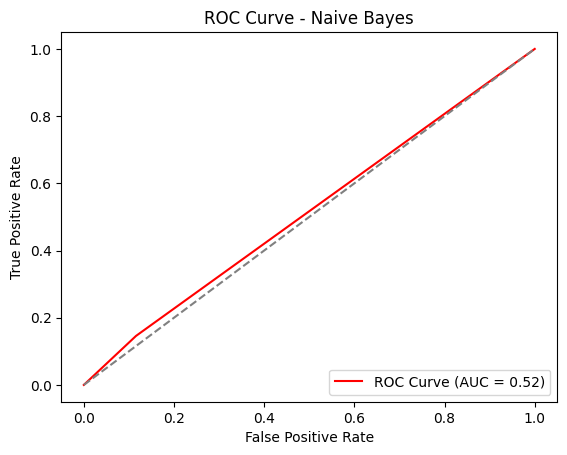

In [ ]:
# NAIVE BAYES PLOTTING
from sklearn.metrics import roc_curve, auc

y_prob = nb.predict_proba(X_test)[:,1]  # probability of fraud (class 1)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# here the NB model is working barely better than random guessing as it is very close to the grey line. A good model ensure the red line is as far as possible from the dotted line

In [ ]:
# KNN-[K Nearest Neighbours]
print('KNN-[K Nearest Neighbours]')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=5)  #searches for the 5 nearest points plotted already
knn.fit(X_train, y_train)

y_pred=knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

KNN-[K Nearest Neighbours]
Accuracy: 0.89375

Confusion Matrix:
 [[429   3]
 [ 48   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       432
           1       0.00      0.00      0.00        48

    accuracy                           0.89       480
   macro avg       0.45      0.50      0.47       480
weighted avg       0.81      0.89      0.85       480



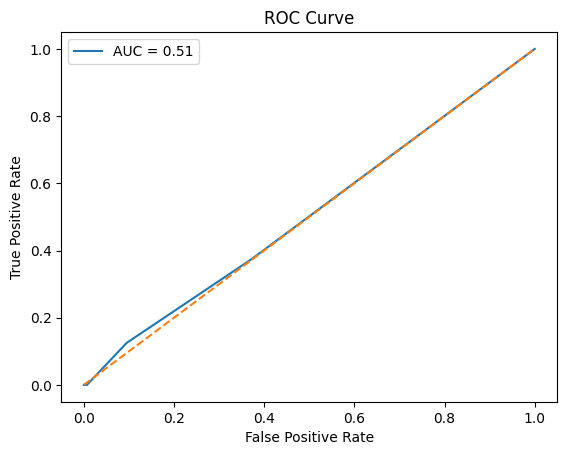

In [ ]:
# KNN PLOTTING
from sklearn.metrics import roc_curve, auc

y_probs = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# more worse than Naive bayes model

In [ ]:
# DECISION TREE
print('DECISION TREE')

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Decision Tree model (with pre-pruning and balanced class handling)
dt = DecisionTreeClassifier(
    criterion='entropy',      #used entropy as it splits better for sensitive decisions like a fraud
    max_depth=5,              #this is a line showing that pre-pruning was used as the max_depth is set to 5
    min_samples_split=20,     #this tells the code to only split a node if it has at least 20 samples in it
    min_samples_leaf=10,      #this tells us that each leaf (final decision) must have at least 10 samples
    class_weight='balanced',  #this tells that don’t just focus on the majority class (not fraud). Give fair importance to the minority class (fraud)
    random_state=42)

dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

DECISION TREE
Accuracy: 0.84375

Confusion Matrix:
 [[402  30]
 [ 45   3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       432
           1       0.09      0.06      0.07        48

    accuracy                           0.84       480
   macro avg       0.50      0.50      0.49       480
weighted avg       0.82      0.84      0.83       480



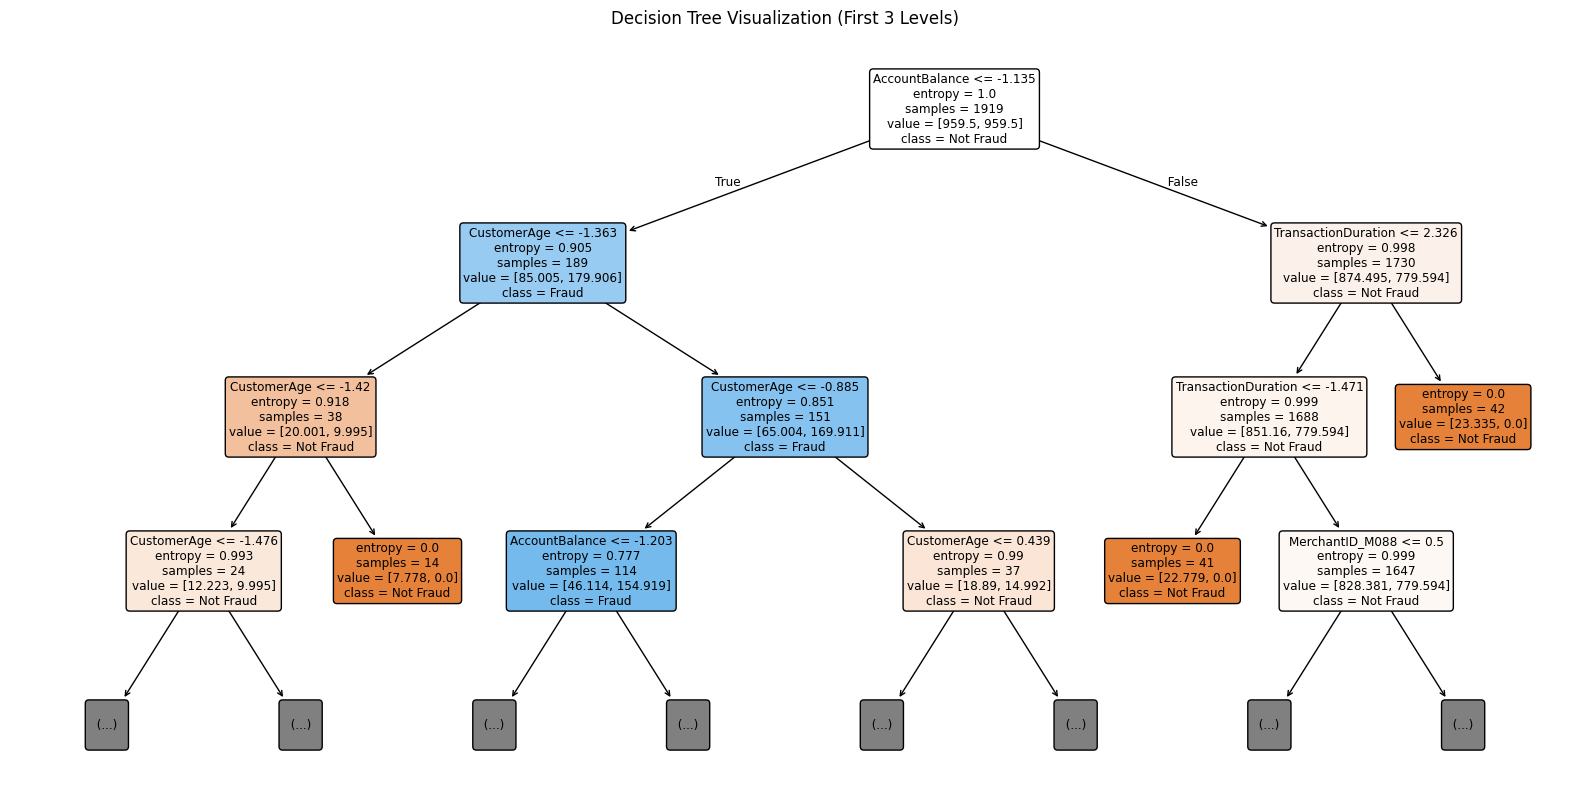

In [ ]:
#DECISION TREE PLOTTING
from sklearn.tree import plot_tree

processed_feature_names=num_feat # coppies the data of num_feat and allows to use it and not affect the other instances where num_feat is used
processed_feature_names.extend(encoder.get_feature_names_out(cat_feat)) # 'encoder.get_feature_names_out(cat_feat)' gets the new column names created by OneHotEncoder after transforming the categorical features
plt.figure(figsize=(20, 10)) # figure size

# Plot the decision tree
plot_tree(dt,
          filled=True,                            # fills nodes with colors based on class purity
          feature_names=processed_feature_names,  # labels each node with the correct feature name
          class_names=['Not Fraud', 'Fraud'],     # labels the output classes (0 → Not Fraud, 1 → Fraud)
          rounded=True,                           # rounds the corners of the box shown in the decision tree
          max_depth=3)                            # show only first 3 levels to avoid clutter

plt.title("Decision Tree Visualization (First 3 Levels)")
plt.show()


In [ ]:
# RANDOM FOREST (using pipeline and column transformer)
print("RANDOM FOREST")

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor = ColumnTransformer([('num', StandardScaler(), num_feat),('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_feat)])

rf=RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('rf', rf)])
# using pipeline and columntransformer we have to split categorical and numerical data, scale the data, do the encoding manually, combine processed data, manually apply all the .fit() to all the test data and fit the model ALL BY OURSELVES!

pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

RANDOM FOREST
Accuracy: 0.8895833333333333
Confusion Matrix:
 [[425   7]
 [ 46   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       432
           1       0.22      0.04      0.07        48

    accuracy                           0.89       480
   macro avg       0.56      0.51      0.51       480
weighted avg       0.83      0.89      0.85       480



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


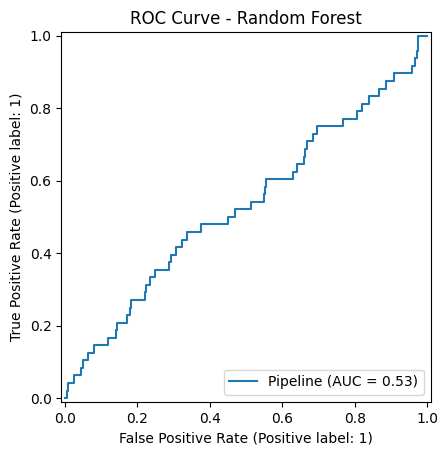

In [ ]:
# RANDOM FOREST PLOTTING

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()